# Results

In [1]:
import src.utils as utils
from src.solvers import pg_solver
from ray import tune

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from tbparse import SummaryReader
import seaborn as sns; sns.set_theme()

2023-07-12 22:46:05.160340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def check_errors(exp_folder):
    """Check for errors in the hyperparameter searches."""
    # Find folders (for each n) inside exp_folder
    folders_n = sorted([os.path.join(exp_folder, folder) for folder in os.listdir(exp_folder)])

    errors = {}
    # Get path for every hyperparameter search
    for folder_n in folders_n:
        folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
        folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
        folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

        # Get number of variables
        num_vars = folder_n.split('/')[-1]

        # Count errors for every hyperparameter search
        errors[f'n={num_vars}'] = {}
        errors[f'n={num_vars}']['num_errors'] = 0
        for i, search_path in enumerate(folder_assumption):
            
            # Restore the GridSearch object
            restored_tuner = tune.Tuner.restore(path=search_path,
                                                trainable=pg_solver,
                                                resume_unfinished=False,
                                                resume_errored=False,
                                                restart_errored=False)
            results = restored_tuner.get_results()
                    
            if results.num_errors > 0:
                #print(f'n={num_vars}, {search_path}, errors = {results.num_errors}, terminated = {results.num_terminated}')

                errors[f'n={num_vars}']['num_errors'] += 1
                errors[f'n={num_vars}'][f'{i}'] = f'path: {search_path}, errors: {results.errors}, num_errors: {results.num_errors},  terminated: {results.num_terminated}'

        errors[f'n={num_vars}']['num_searches'] = len(folder_assumption)
        #print(f'Total errors for n = {num_vars}: {errors}. Total searchs: {len(folder_assumption)}\n')

    # Print keys and values
    for key, value in errors.items():
        print(key)
        print(value)


def best_trials_csv(exp_folder, csv_path):
    """
    Generate dataframe with best trials from hyperparameter searches,
    and save it as a csv file in csv_path.
    """
    # Find folders (for each n) inside exp_folder
    folders_n = sorted([os.path.join(exp_folder, folder) for folder in os.listdir(exp_folder)])
    
    list_df = []
    for folder_n in folders_n:
        # Get path for every hyperparameter search
        folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
        folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
        folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

        # Extract info from search_path
        for i, search_path in enumerate(folder_assumption):
            # Create experiment id
            split_path = search_path.split("/")
            n = split_path[2]
            m = split_path[3]
            i = split_path[4][-2:]
            s = split_path[5]
            exp_id = f'{n}/{m}/{i}/{s}'
            
            # Restore the GridSearch object
            restored_tuner = tune.Tuner.restore(path=search_path,
                                                trainable=pg_solver,
                                                resume_unfinished=False,
                                                resume_errored=False,
                                                restart_errored=False)
            results = restored_tuner.get_results()
            
            # Get dataframe with best trials. A best trial is a trial with the max value of num_sat_eval
            df_base = results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')

            # Keep only rows with the max value
            df_best = df_base[df_base['num_sat_eval'] == df_base['num_sat_eval'].max()]

            # keep only columns of interest
            #df_best = df_base[cols_keep]

            # Add n, m, i, s to df_best
            df_best.insert(0, 'exp', exp_id)
            df_best.insert(1, 'n', int(n))
            df_best.insert(2, 'm', int(m))
            df_best.insert(3, 'i', int(i))
            df_best.insert(4, 's', s)

            # Add r, and frac_sat to df_best
            df_best.insert(2, 'r', df_best['m'] / df_best['n'])
            df_best.insert(6, 'frac_sat', df_best['num_sat_eval'] / df_best['m'])

            list_df.append(df_best)

    # Concatenate the list of dataframes
    df = pd.concat(list_df, ignore_index=True)
    df.to_csv(csv_path, index=False)


def best_trials2best_feaures(df_best_trials, feature):
    """Given a dataframe with the best trials, return a dataframe with the fraction of time each value
    of the feature of interest happens for each n, r, s.
    """
    # Grouped by n, r, s count the number of times each feature of interest happens
    df_feature = df_best_trials.groupby(['n', 'r', 's', feature]).count().reset_index()
    df_feature = df_feature[['n', 'r', 's', feature, 'exp']]
    df_feature = df_feature.rename(columns={'exp': 'count'})

    # Unique values in column feature
    feature_vals = df_feature[feature].unique()
    feature_vals

    # Unique values in column s
    searches = df_feature['s'].unique()
    searches

    # Generate dictionary with n, r, s as keys and feature_vals as values initialized to 0
    dic_ft = {}
    for n in df_feature['n'].unique():
        for r in df_feature['r'].unique():
            for s in searches:
                key = f'{n:04d}/{r}/{s}'
                dic_ft[key] = {'n': n, 'r': r, 's': s}
                for feature_val in feature_vals:
                    dic_ft[key][feature_val] = 0

    # Count the number of times each value of the feature of interest happens
    # Iterate over each row of df_feature
    for index, row in df_feature.iterrows():
        # Get values
        n, r, s, ft, count = row['n'], row['r'], row['s'], row[feature], row['count']
        # Update dictionary
        dic_ft[f'{n:04d}/{r}/{s}'][ft] = count

    # Create dataframe from dictionary
    df_ft = pd.DataFrame.from_dict(dic_ft, orient='index')

    # Normalize counts
    df_ft['num_best_trials'] = 0
    for feture_val in feature_vals:
        df_ft['num_best_trials'] += df_ft[feture_val]
    for feture_val in feature_vals:
        df_ft[feture_val] = df_ft[feture_val] / df_ft['num_best_trials']
    
    # Drop num_best_trials column
    df_ft = df_ft.drop(columns=['num_best_trials'])
    
    return df_ft

### Check for errors

In [4]:
# Check for errors in the hyperparameter searches
exp_folder = 'hypersearch/pg_solver'
check_errors(exp_folder)

n=0010
{'num_errors': 0, 'num_searches': 120}
n=0020
{'num_errors': 0, 'num_searches': 120}
n=0030
{'num_errors': 0, 'num_searches': 120}
n=0040
{'num_errors': 0, 'num_searches': 120}
n=0050
{'num_errors': 0, 'num_searches': 120}
n=0100
{'num_errors': 0, 'num_searches': 120}


### Build dataframe with best trials

In [4]:
# Generate dataframe with best trials and save it as a csv file
exp_folder = 'hypersearch/pg_solver'
csv_path = 'results/df_best_trials.csv'

# Build csv file
best_trials_csv(exp_folder, csv_path)

# Load df_best_trials from csv
df_best_trials = pd.read_csv(csv_path)
df_best_trials

,exp,n,r,m,i,s,frac_sat,num_sat,loss,num_sat_eval,...,config/n2v_dir,config/n2v_lr,config/n2v_num_epochs,config/n2v_p,config/n2v_pretrained,config/n2v_q,config/n2v_verbose,config/n2v_walk_len,config/n2v_walks_per_node,config/n2v_workers
0,0010/0010/01/arch,10,1.0,10,1,arch,1.000000,8.90625,-61.995412,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0010/0010/01/arch,10,1.0,10,1,arch,1.000000,8.81250,-61.068308,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0010/0010/01/arch,10,1.0,10,1,arch,1.000000,8.96875,-62.555747,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0010/0010/01/arch,10,1.0,10,1,arch,1.000000,9.03125,-62.650649,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0010/0010/01/arch,10,1.0,10,1,arch,1.000000,8.84375,-60.038612,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11217,0100/0450/05/arch,100,4.5,450,5,arch,0.935556,392.56250,-26996.405002,421.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11218,0100/0450/05/arch,100,4.5,450,5,arch,0.935556,394.78125,-27266.661330,421.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11219,0100/0450/05/arch,100,4.5,450,5,arch,0.935556,393.90625,-16900.780084,421.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11220,0100/0450/05/baseline,100,4.5,450,5,baseline,0.942222,394.15625,-27319.798705,424.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Average fraction of satisfiable clauses as the radius r increased.
The average is over the five different instances and the six different values of n.

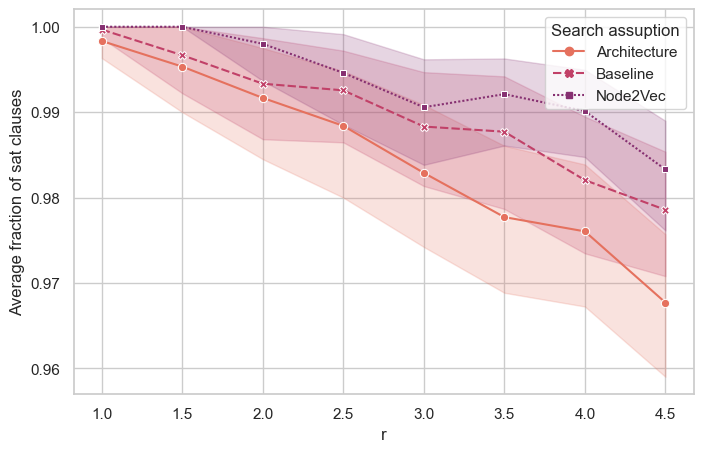

In [4]:
# Load df_best_trials from csv
csv_path = 'results/df_best_trials.csv'
df_best_trials = pd.read_csv(csv_path)

# Keep only exp, n, r, i, s, frac_sat
df_max_frac_sat = df_best_trials[['exp', 'n', 'r', 'i', 's', 'frac_sat']]

# Rename s to search
df_max_frac_sat = df_max_frac_sat.rename(columns={'s': 'search'})

# Drop duplicates, keeping the fraction of satisfiable clauses with the highest value for each experiment
df_max_frac_sat = df_max_frac_sat.drop_duplicates(subset=['exp'])

# In 'search' column replace 'arch' with 'Architercture', 'baseline' with 'Baseline', and 'node2vec' with 'Node2Vec'
df_max_frac_sat['search'] = df_max_frac_sat['search'].replace({'arch': 'Architecture', 'baseline': 'Baseline', 'node2vec': 'Node2Vec'})

# Generate figure
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

sns.lineplot(data=df_max_frac_sat, x="r", y="frac_sat", hue="search", style="search", errorbar=('ci', 99), markers=True, palette='flare', legend='auto')
plt.ylabel('Average fraction of sat clauses')
plt.legend(title='Search assuption', loc='upper right')

#plt.tight_layout()
#plt.show()
plot_path = 'results/frac_sat.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Average fraction of satisfiable clauses as the radius r increase for n=10, 20, 30, 40, 50, and 100.
The average is over the five different instances for each n, and plots are arranged from left to right and top to bottom.

<Figure size 640x480 with 0 Axes>

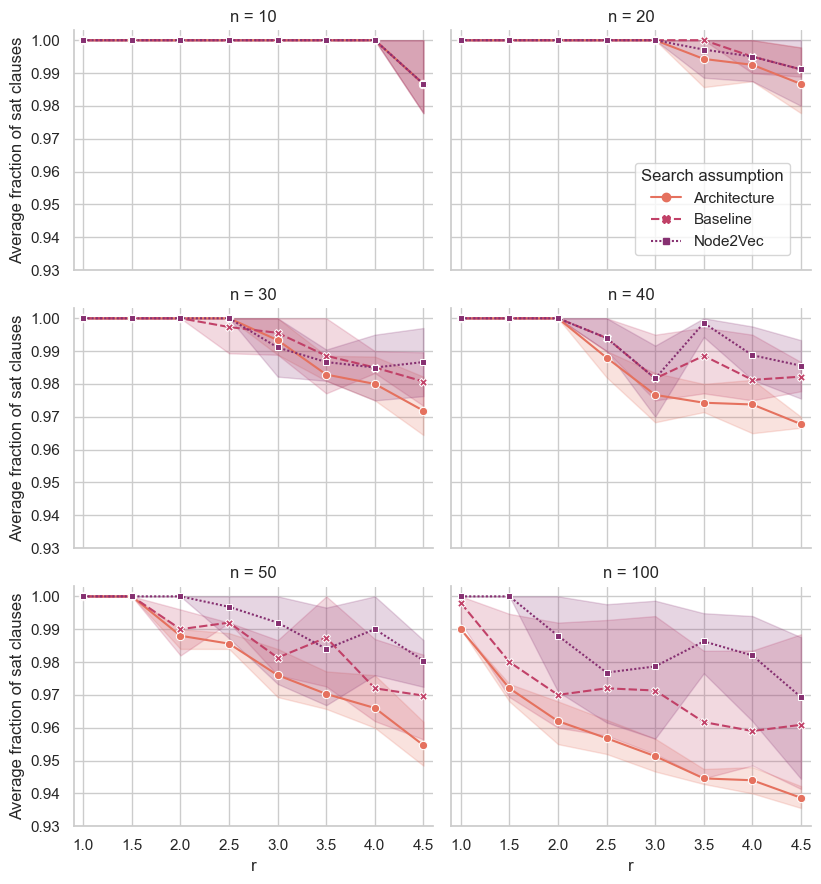

In [5]:
# Load df_best_trials from csv
csv_path = 'results/df_best_trials.csv'
df_best_trials = pd.read_csv(csv_path)

# Keep only exp, n, r, i, s, frac_sat
df_max_frac_sat = df_best_trials[['exp', 'n', 'r', 'i', 's', 'frac_sat']]

# Rename s to search
#df_max_frac_sat = df_max_frac_sat.rename(columns={'s': 'search'})

# Drop duplicates, keeping the fraction of satisfiable clauses with the highest value for each experiment
df_max_frac_sat = df_max_frac_sat.drop_duplicates(subset=['exp'])

# Generate figure
plt.figure()
sns.set_theme(style="whitegrid")
g = sns.relplot(data=df_max_frac_sat, x="r", y="frac_sat", hue="s", style="s", col="n", col_wrap=2,
                errorbar=('ci', 99), markers=True, palette='flare', kind='line',
                facet_kws=dict(sharex=True, sharey=True), height=3, aspect=1.4, legend='auto')

g.axes[0].set_ylim(0.93, 1.003)
g.axes[1].set_ylim(0.93, 1.003)
g.axes[2].set_ylim(0.93, 1.003)
g.axes[3].set_ylim(0.93, 1.003)
g.axes[4].set_ylim(0.93, 1.003)
g.axes[5].set_ylim(0.93, 1.003)

g.axes[0].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[1].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[2].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[3].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[4].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[5].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
# g.axes[0].set_yticklabels([])  # Remove y tick labels

g.axes[0].set_xlim(0.9, 4.6)
g.axes[1].set_xlim(0.9, 4.6)
g.axes[2].set_xlim(0.9, 4.6)
g.axes[3].set_xlim(0.9, 4.6)
g.axes[4].set_xlim(0.9, 4.6)
g.axes[5].set_xlim(0.9, 4.6)

g.axes[0].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[1].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[2].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[3].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[4].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[5].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])

g.axes[0].set_ylabel('Average fraction of sat clauses')
g.axes[1].set_ylabel('')
g.axes[2].set_ylabel('Average fraction of sat clauses')
g.axes[3].set_ylabel('')
g.axes[4].set_ylabel('Average fraction of sat clauses')
g.axes[5].set_ylabel('')

# Configure legend
leg = g._legend
leg.set_bbox_to_anchor([0.83, 0.75])
new_labels = ['Architecture', 'Baseline', 'Node2Vec']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
leg.set_title('Search assumption')
leg.set_frame_on(True)

#plt.tight_layout()
#plt.show()
plot_path = 'results/frac_sat_by_n.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Average number of best trials
The average is over the five different instances and the three different search assumptions.

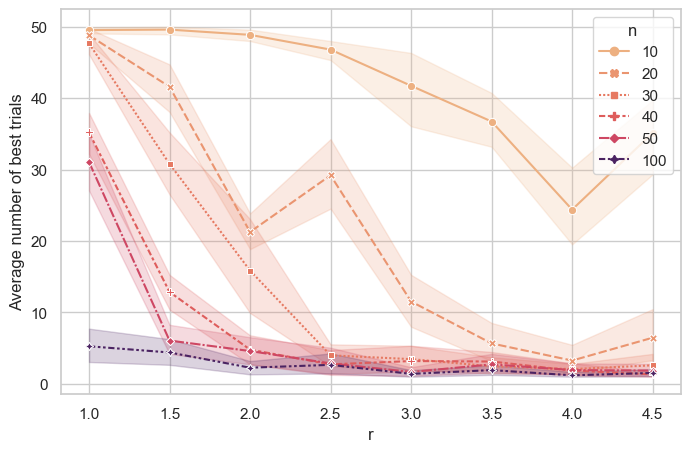

In [6]:
# Load df_best_trials from csv
csv_path = 'results/df_best_trials.csv'
df_best_trials = pd.read_csv(csv_path)

# Group by n, r, s, i, count number of times each combination appears (num best trials)
df_num_bt = df_best_trials.groupby(['n', 'r', 's', 'i']).size().reset_index(name='num_best_trials')

# Generate figure
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_num_bt, x="r", y="num_best_trials", hue="n", style="n", errorbar=('ci', 99), markers=True, palette='flare', legend='auto')
plt.ylabel('Average number of best trials')
plt.legend(title='n', loc='upper right')

#plt.tight_layout()
#plt.show()
plot_path = 'results/num_best_trials.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times a Transformer decoder is present in the best trials

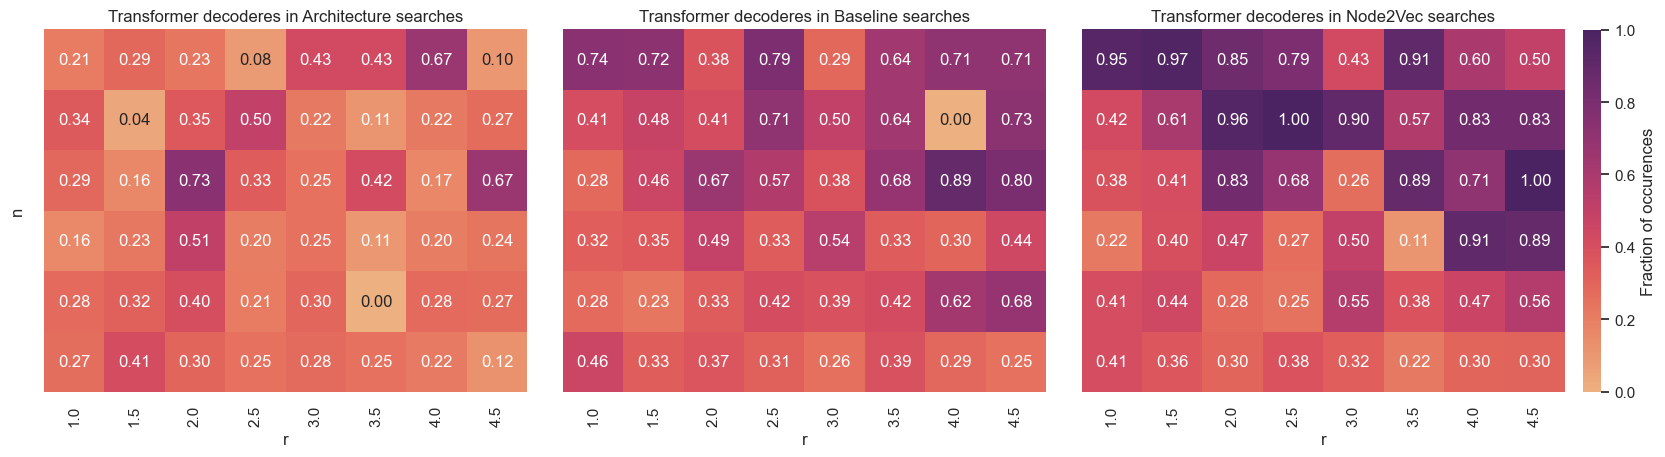

In [7]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/decoder'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Drop some column to keep only Transformer
df_ft = df_ft.drop(columns=['GRU', 'LSTM'])

# Generate list of dataframes
list_df = []
for s in ['arch', 'baseline', 'node2vec']:
    # Get df for each search assumption
    # Keep only rows with specific s
    df_s = df_ft[df_ft['s'] == s]
    # Convert column r to row
    df_s = df_s.pivot(index='n', columns='r', values=['Transformer'])
    # Order from largest to smallest n
    df_s = df_s.reindex(index=df_s.index[::-1])
    list_df.append(df_s)


# Generate plot
fig, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(21, 5))
sns.set_theme(style="whitegrid")

# Subplot 1: Architecture Search
inst = 0
sns.heatmap(list_df[0], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_title('Transformer decoderes in Architecture searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)

# Subplot 2: Baseline Search
inst = 1
sns.heatmap(list_df[1], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('Transformer decoderes in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)

# Subplot 3: Node2Vec Search
inst = 2
sns.heatmap(list_df[2], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('Transformer decoderes in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)

#plt.tight_layout()
plt.subplots_adjust(wspace=-.12, hspace=0)
#plt.show()

plot_path = 'results/transformer.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times a non-zero baseline is present in the best trials

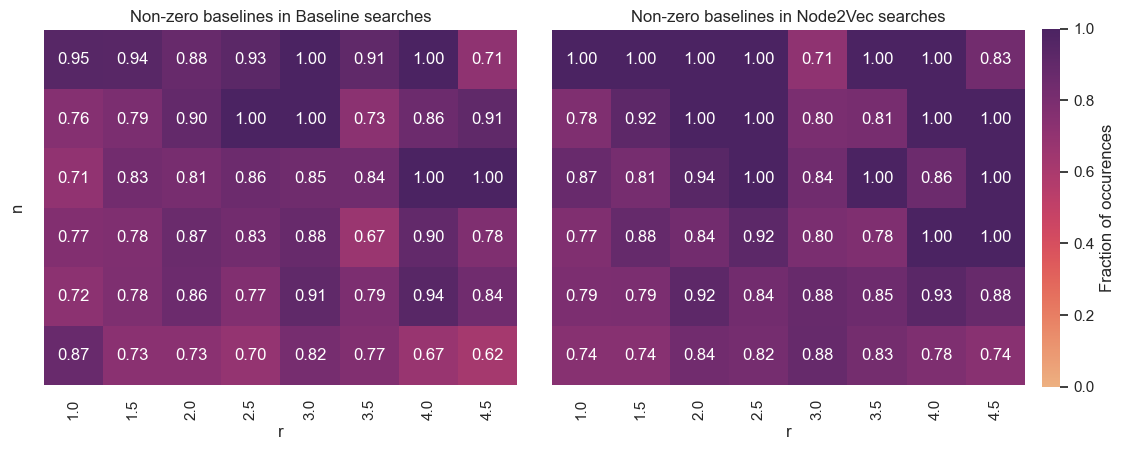

In [8]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with baseline or node2vec search assumption
df_ft = df_ft[df_ft['s'] != 'arch']

# Sum ema, greedy, sample baselines
df_ft['baseline'] =  df_ft['ema'] + df_ft['greedy'] + df_ft['sample']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['zero', 'ema', 'greedy', 'sample'])

# Convert column r to row (for baseline search)
df_b = df_ft[df_ft['s'] == 'baseline'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_b = df_b.reindex(index=df_b.index[::-1])

# Convert column r to row (for node2vec search)
df_n = df_ft[df_ft['s'] == 'node2vec'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_n = df_n.reindex(index=df_n.index[::-1])


# Generate plot
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(14, 5))

# Subplot 1: Baseline Search
inst = 0
sns.heatmap(df_b, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.94})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_title('Non-zero baselines in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)


# Subplot 2: Node2Vec Search
inst = 1
sns.heatmap(df_n, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.93})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('Non-zero baselines in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)

#plt.tight_layout()
plt.subplots_adjust(wspace=-.12, hspace=0)
#plt.show()

plot_path = 'results/baseline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Average fraction of times the different baselines are present in the best trials

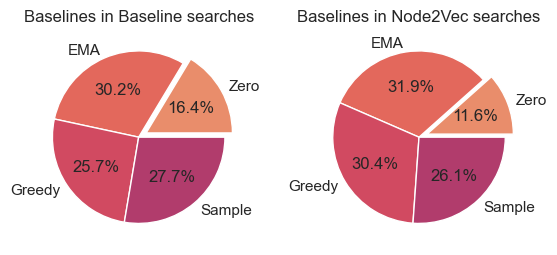

In [9]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Eliminate rows with s==arch
df_ft = df_ft[df_ft['s'] != 'arch']

# Keep rows with s=baseline an columns zero, ema, greedy and sample
df_b = df_ft[df_ft['s'] == 'baseline']
df_b = df_b[['zero', 'ema', 'greedy', 'sample']]
# Get mean of each column
mean_b = df_b.mean(axis=0)

# Keep rows with s=node2vec an columns zero, ema, greedy and sample
df_n = df_ft[df_ft['s'] == 'node2vec']
df_n = df_n[['zero', 'ema', 'greedy', 'sample']]
# Get mean of each column
mean_n = df_n.mean(axis=0)


# Generate plot
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
sns.set_theme(style="whitegrid")

# Labels for data
labels = ['Zero', 'EMA', 'Greedy', 'Sample']
# Declaring exploding pie
explode = [0.1, 0, 0, 0]
# Define Seaborn color palette to use
palette_color = sns.color_palette('flare')

# Subfigure 1: Baseline Search
axes[0].pie(mean_b, labels=labels, colors=palette_color, explode=explode, autopct='%.1f%%')
axes[0].set_title('Baselines in Baseline searches')

# Subfigure 2: Node2Vec Search
axes[1].pie(mean_n, labels=labels, colors=palette_color, explode=explode, autopct='%.1f%%')
axes[1].set_title('Baselines in Node2Vec searches')


plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.tight_layout()
#plt.show()

plot_path = 'results/baseline_pie.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

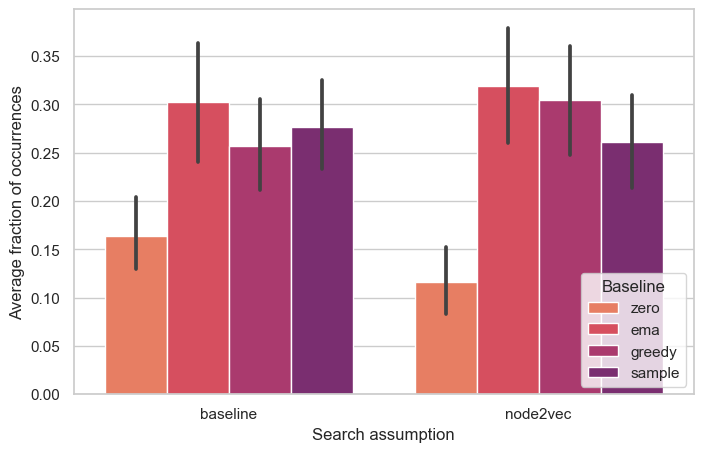

In [24]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Eliminate rows with s=arch
df_ft = df_ft[df_ft['s'] != 'arch']

# Convert zero emma greedy and sample columns into rows
df_ft = df_ft.melt(id_vars=['n', 'r', 's'],
                   value_vars=['zero', 'ema', 'greedy', 'sample'],
                   var_name='baseline',
                   value_name='fraction')


# Generate plot
plt.figure(figsize = (8,5))
sns.set_theme(style="whitegrid")

sns.barplot(x = "s", 
            y = "fraction", 
            data = df_ft,
            errorbar=('ci', 99),
            palette = "flare",
            saturation = 1,
            hue='baseline')

plt.ylabel('Average fraction of occurrences')
plt.xlabel('Search assumption')
plt.legend(title='Baseline', loc='lower right')
#plt.tight_layout()
#plt.show()

plot_path = 'results/baseline_bars.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times a Node2Vec embedding is present in the best trials

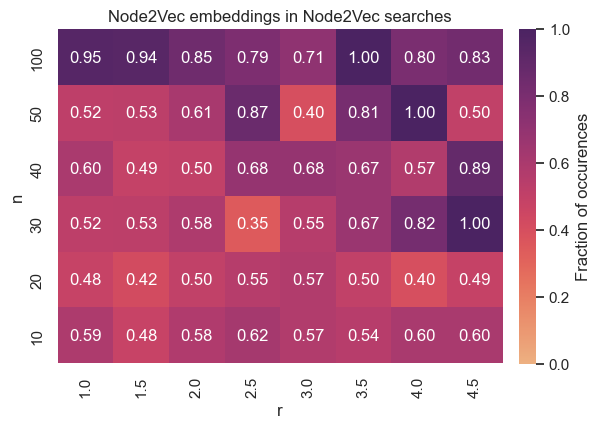

In [10]:
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/dec_var_initializer'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with s=node2vec
df_ft = df_ft[df_ft['s'] == 'node2vec']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['BasicVar'])

# Convert column r to row (for baseline search)
df_ft = df_ft.pivot(index='n', columns='r', values=['Node2VecVar'])
# Order from largest to smallest n
df_ft = df_ft.reindex(index=df_ft.index[::-1])


# Generate plot
fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(7, 5))
sns.set_theme(style="whitegrid")

# Subplot 1: Node2Vec Search
sns.heatmap(df_ft, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=ax,
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 0.87})
ax.set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
ax.set_xlabel('r')
ax.set_title('Node2Vec embeddings in Node2Vec searches')
#axes[inst].collections[0].colorbar.ax.set_visible(False)


#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

plot_path = 'results/node2vec.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

### Fraction of times Transformer decoders, non-zero baselines, and Node2Vec embeddings are present in the best trials.

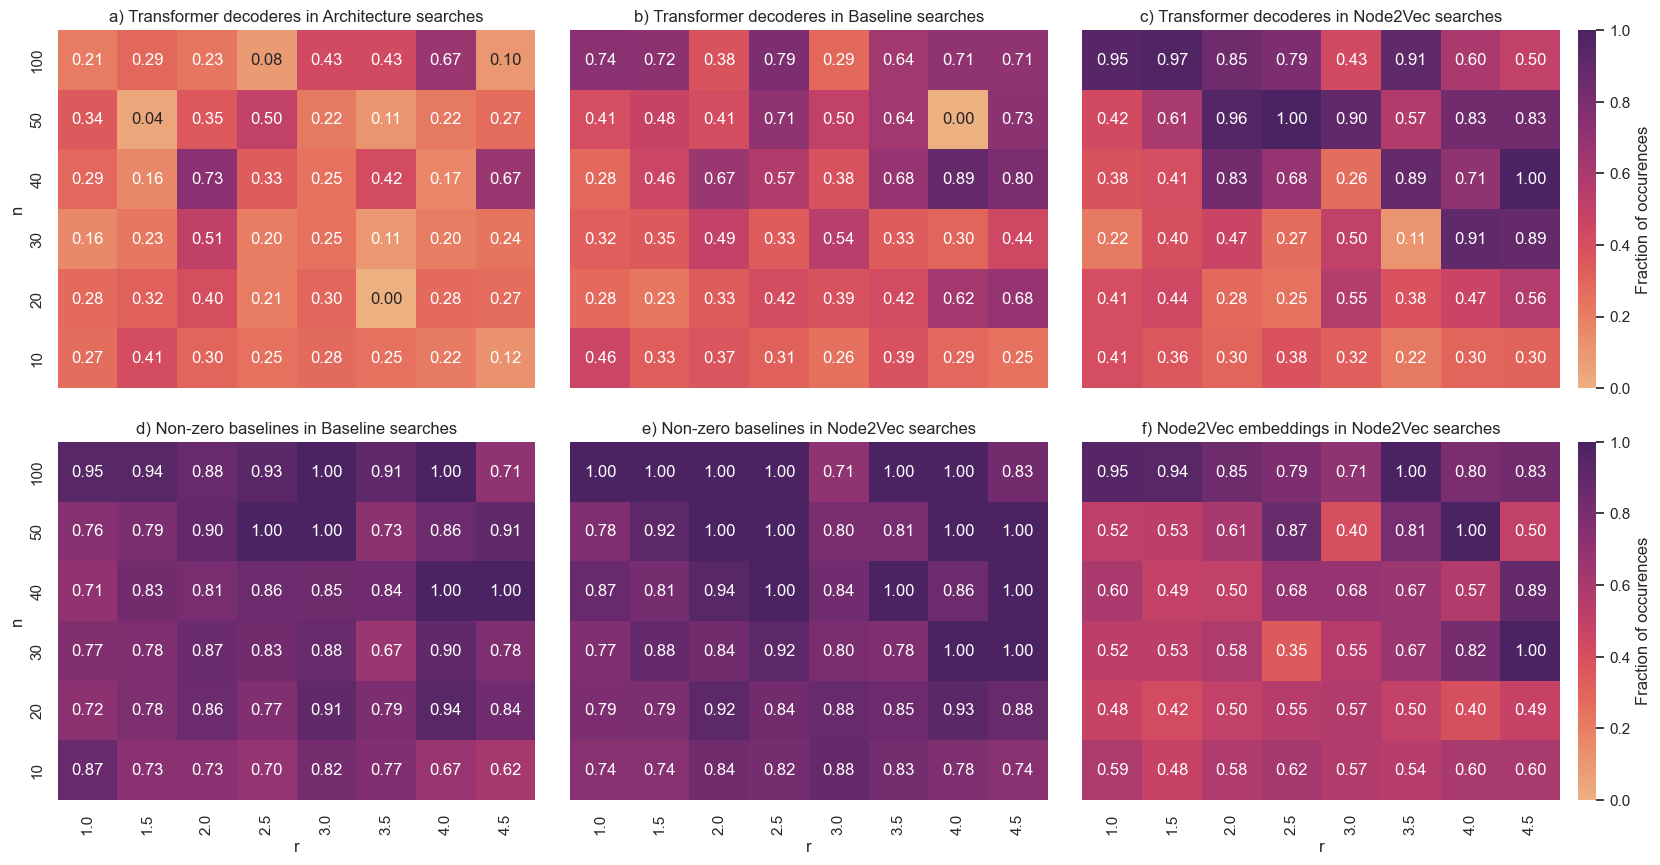

In [11]:
# Transformer Decoderes
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/decoder'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Drop some column to keep only Transformer
df_ft = df_ft.drop(columns=['GRU', 'LSTM'])

# Generate list of dataframes
list_df_t = []
for s in ['arch', 'baseline', 'node2vec']:
    # Get df for each search assumption
    # Keep only rows with specific s
    df_s = df_ft[df_ft['s'] == s]
    # Convert column r to row
    df_s = df_s.pivot(index='n', columns='r', values=['Transformer'])
    # Order from largest to smallest n
    df_s = df_s.reindex(index=df_s.index[::-1])
    list_df_t.append(df_s)


# Non-zero baselines 
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/baseline'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with baseline or node2vec search assumption
df_ft = df_ft[df_ft['s'] != 'arch']

# Sum ema, greedy, sample baselines
df_ft['baseline'] =  df_ft['ema'] + df_ft['greedy'] + df_ft['sample']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['zero', 'ema', 'greedy', 'sample'])

# Convert column r to row (for baseline search)
df_b = df_ft[df_ft['s'] == 'baseline'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_b_b = df_b.reindex(index=df_b.index[::-1])

# Convert column r to row (for node2vec search)
df_n = df_ft[df_ft['s'] == 'node2vec'].pivot(index='n', columns='r', values=['baseline'])
# Order from largest to smallest n
df_b_n = df_n.reindex(index=df_n.index[::-1])


# Node2Vec embeddings
# Generate dataframe with fraction of times each value of the feature of interest happens
csv_path = 'results/df_best_trials.csv'
feature = 'config/dec_var_initializer'
df_best_trials = pd.read_csv(csv_path)
df_ft = best_trials2best_feaures(df_best_trials, feature)

# Keep only rows with s=node2vec
df_ft = df_ft[df_ft['s'] == 'node2vec']

# Drop irrelevant columns
df_ft = df_ft.drop(columns=['BasicVar'])

# Convert column r to row (for baseline search)
df_ft = df_ft.pivot(index='n', columns='r', values=['Node2VecVar'])
# Order from largest to smallest n
df_n_n = df_ft.reindex(index=df_ft.index[::-1])


# Generate plot
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(21, 10))

# Subplot a) Transformer decoderes in architecture searches
inst = (0, 0)
sns.heatmap(list_df_t[0], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('')
axes[inst].set_title('a) Transformer decoderes in Architecture searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)
#axes[inst].text(0.0, 1.02, label_i, weight='bold', transform=axes[inst].transAxes)

# Subplot b) Transformer decoderes in baseline searches
inst = (0, 1)
sns.heatmap(list_df_t[1], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('b) Transformer decoderes in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)
#axes[inst].text(0.0, 1.02, label_i, weight='bold', transform=axes[inst].transAxes)

# Subplot c) Transformer decoderes in node2vec searches
inst = (0, 2)
label_i = 'c)'
sns.heatmap(list_df_t[2], annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('c) Transformer decoderes in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)
#axes[inst].text(0.0, 1.02, label_i, weight='bold', transform=axes[inst].transAxes)


# Subplot d) Non-zero baseline in baseline searches
inst = (1, 0)
sns.heatmap(df_b_b, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_title('d) Non-zero baselines in Baseline searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)

# Subplot e) Non-zero baseline in node2vec searches
inst = (1, 1)
sns.heatmap(df_b_n, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_yticklabels([])
axes[inst].set_ylabel('')
axes[inst].set_title('e) Non-zero baselines in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(False)


# Subplot f) Node2Vec embeddings in node2vec searches
inst = (1, 2)
sns.heatmap(df_n_n, annot=True, vmin=0, vmax=1, cmap='flare', cbar=True, fmt=".2f", square=True, ax=axes[inst],
            cbar_kws={'label': 'Fraction of occurences', 'pad': 0.03, "shrink": 1.0})
axes[inst].set_xticklabels([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
axes[inst].set_xlabel('r')
axes[inst].set_ylabel('')
axes[inst].set_title('f) Node2Vec embeddings in Node2Vec searches')
axes[inst].collections[0].colorbar.ax.set_visible(True)


#plt.tight_layout()
plt.subplots_adjust(wspace=-0.15, hspace=0.15)
#plt.show()

plot_path = 'results/fraction_occurences.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)